In [42]:
import numpy as np
from numpy.linalg import det, inv, svd, norm
import matplotlib.pyplot as plt


def RungeKutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def analyse_point(F):
    eps = 10**(-4)
    dets = []
    for col in range(len(F[0])):
        cols = [i for i in range(len(F[0])) if i != col]
        dets.append(det(F[:, cols]))
    if (np.abs(dets) < eps).all():
        return True, np.round(dets, 4)
    return False, np.round(dets, 4)

def parameter_change(p_idx, diff, x_cur, y_cur, x_next):
  max_idx = np.argmax(diff)
  id_p = 0
  id_diff = 0
  for i in range(len(x_cur)): 
    if x_cur[i] == p_idx:
      id_p = i
    if x_cur[i] == max_idx:
      id_diff = i
  x_cur[id_p] , x_cur[id_diff] = x_cur[id_diff] , x_cur[id_p]

def continuation_parameter(Xs, Ys, x_cur, y_cur, x_next):
    if len(Ys) < 3:
        Ys.append(y_cur)
        Xs.append(x_cur)
    else:
        Ys[0], Ys[1], Ys[2] = Ys[1], Ys[2], y_cur
        Xs[0], Xs[1], Xs[2] = Xs[1], Xs[2], x_cur
    a0 = Ys[0]
    if len(Ys) == 1: 
      return a0
    a1 = (Ys[1] - Ys[0])/(Xs[1]-Xs[0])
    if len(Ys) == 2: 
      return a0 + a1*(x_next-Xs[0])
    yx1x2 = (Ys[2]-Ys[1])/(Xs[2]-Xs[1])
    a2 = (yx1x2 - a1)/(Xs[2]-Xs[0])
    y_next = a0 + a1*(x_next-Xs[0]) + a2*(x_next-Xs[0])*(x_next-Xs[1])
    return y_next

def biff_branch_searcher(start_parameter, x_cur, y_cur, x_next):
  while 1 == 1:
    p, diff, is_inf = continuation_parameter(start_parameter[0],start_parameter[1], x_cur, y_cur, x_next)
    if is_inf:
      break
    print('Parameter change')
    parameter_change(p, diff,x_cur, x_cur, y_cur, x_next)

def shoot(time_steps, y_init, system, params, bc, bc_params, solver=RungeKutta):
    eps = 10**(-4)
    t_left = time_steps[len(time_steps)//2::-1]
    t_right = time_steps[len(time_steps)//2:]
    cnt = 0
    F = np.zeros(len(y_init)*len(y_init)).reshape(len(y_init), len(y_init))
    while(True):
        ys = np.concatenate((solver(t_left, y_init, system, params)[::-1],
              solver(t_right, y_init, system, params)[1:]))
        rs = bc(ys, bc_params)
        if (np.abs(rs) < eps).all():
            break
        F = np.zeros(len(y_init)*len(y_init)).reshape(len(y_init), len(y_init))
        for i in range(len(y_init)):
            yi_approx = y_init.copy()
            yi_approx[i] += eps
            yis = np.concatenate((solver(t_left, yi_approx, system, params)[::-1],
                   solver(t_right, yi_approx, system, params)[1:]))
            rsi = bc(yis, bc_params)
            # заполнение матрицы Фреше
            F[:, i] = (rsi - rs) / eps      
        cnt += 1
        if det(F) < 10**(-9):
            return cnt, ys, det(F), svd(F)[1], F
        # обновление приближение по формуле ньютона
        y_init = y_init - np.dot(np.linalg.inv(F), rs)
    ys = np.concatenate((solver(t_left, y_init, system, params)[::-1],
                   solver(t_right, y_init, system, params)[1:]))
    
    return cnt, ys, det(F), svd(F)[1]



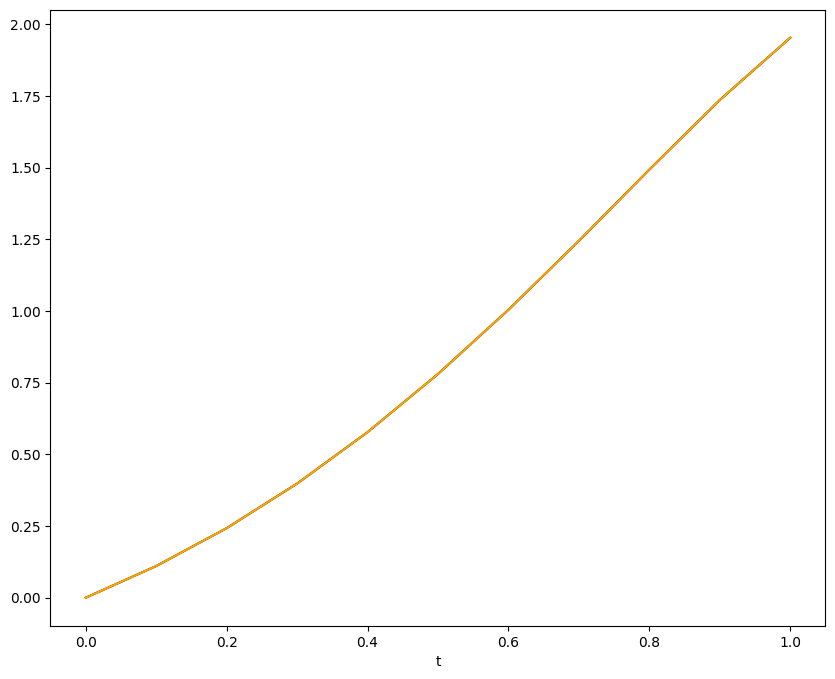

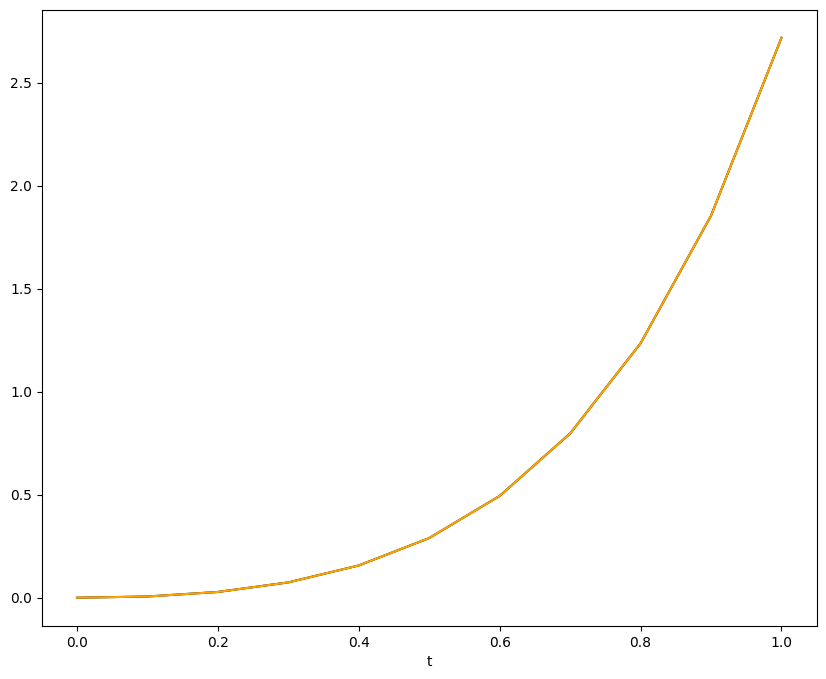

In [43]:

# def dV(Q):
#     return Q
# def dQ(V, Q, R, C, I=0.00003):
#     T = 2.1
#     return -T * R / I * Q - T**2/ I / C * V

# def system(t, xy, params):
#     V, Q = xy
#     R, _, C = params
#     return np.array([dV(Q), dQ(V, Q, R, C)])

def system(t, xy, params):
    x,y = xy
    dx = x - y + np.exp(t)
    dy = x + 3*y
    return np.array([dx, dy])

def bc(xy_span, bc_params):
    x, y = xy_span[:,0], xy_span[:,1]
    r1 = x[0] - bc_params[0]
    r2 = y[-1] - bc_params[-1]
    return np.array([r1,r2])

def true_x(t):
    return (2-t)*np.exp(2*t)-2*np.exp(t)
def true_y(t):
    return (t-1)*np.exp(2*t)+np.exp(t)
    
h = 0.1
par= np.array([0.15, 0.15, 220., 
                        250., 0.01, 0.01]).reshape(3, 2)

steps, xy_span, d, svd = shoot(np.arange(0,1+h,h), [0,0], system, par, bc, [0, np.e])

fig, ax = plt.subplots(1,1,figsize=(10, 8))
plt.plot(np.arange(0,1+h,h), true_x(np.arange(0,1+h,h)), c='black')
plt.plot(np.arange(0,1+h,h), xy_span[:,0], c='orange')
plt.xlabel("x")
plt.xlabel("t")
plt.show()

fig, ax = plt.subplots(1,1,figsize=(10, 8))
plt.plot(np.arange(0,1+h,h), xy_span[:,1], c='black')
plt.plot(np.arange(0,1+h,h), true_y(np.arange(0,1+h,h)), c='orange')
plt.xlabel("y")
plt.xlabel("t")
plt.show()
